In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
def poly_functions_from_coeffs(coeffs, device='cpu'):
    """
    Build f(z), f'(z) and roots for a given real/complex coefficient list.

    Parameters
    ----------
    coeffs : list[float|complex]
        Leading coefficient first: [a_n, a_(n-1), ..., a_0].
    device : str
        Torch device.

    Returns
    -------
    f : callable
        Polynomial evaluator on torch tensors.
    fprime : callable
        Derivative evaluator on torch tensors.
    roots : torch.Tensor, shape (n,), complex64
        All complex roots.
    """
    c = torch.tensor(coeffs, dtype=torch.complex64, device=device)
    n = len(c) - 1
    leading = c[0]

    # Horner form for the polynomial
    def f(z):
        res = torch.zeros_like(z) + c[0]
        for coef in c[1:]:
            res = res * z + coef
        return res

    # Derivative coefficients: (n-i) * a_i
    dcoeffs = torch.stack([(n - i) * c[i] for i in range(n)])

    def fprime(z):
        res = torch.zeros_like(z) + dcoeffs[0]
        for coef in dcoeffs[1:]:
            res = res * z + coef
        return res

    # Roots via companion matrix
    comp = torch.zeros((n, n), dtype=torch.complex64, device=device)
    comp[1:, :-1] = torch.eye(n - 1, dtype=torch.complex64, device=device)
    comp[0, :] = -c[1:] / leading
    roots = torch.linalg.eigvals(comp)

    return f, fprime, roots

In [3]:
def newton_fractal(
    coeffs,
    resolution=1024,
    iter_max=40,
    device='cpu',
    extent=1.5,
    roots_base=None
):
    """
    Newton fractal for an arbitrary polynomial.

    coeffs   : list of coefficients [a_n, ..., a_0]
    extent   : half-side of the square in the complex plane (±extent)
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    H = W = resolution

    # Complex grid in [-extent, extent]²
    re = torch.linspace(-extent, extent, W, device=device)
    im = torch.linspace(-extent, extent, H, device=device)
    z = re[None, :].expand(H, W) + 1j * im[:, None].expand(H, W)
    z = z.to(torch.complex64)

    f, fprime, roots = poly_functions_from_coeffs(coeffs, device)
    if roots_base is not None:
        roots = torch.tensor(roots_base, dtype=torch.complex64, device=device)

    for _ in range(iter_max):
        z = z - f(z) / fprime(z)        # Newton update over the whole grid

    # Each pixel → closest root index
    dist = torch.abs(z[..., None] - roots)      # (H, W, num_roots)
    root_id = dist.argmin(dim=-1).cpu()         # (H, W) on host
    return root_id, z

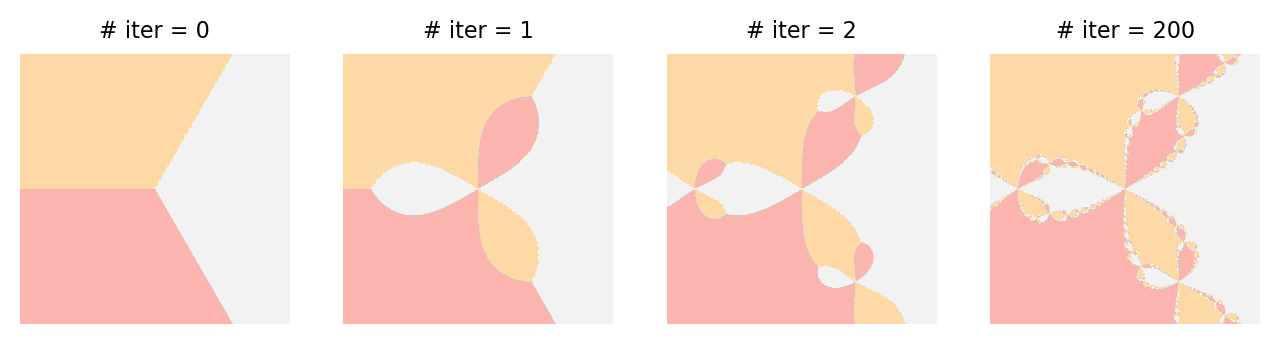

In [4]:
extent = 1
resolution = 1024
js = [0, 1, 2, 200]

coefs = [1, 0, 0, -1]
fig, axs = plt.subplots(1, 4, figsize=(8,2), dpi=200)
for (j, ax) in zip(js, axs):
    idx, z = newton_fractal(coefs, resolution=resolution, iter_max=j, extent=extent, device='cpu')
    ax.imshow(idx, cmap='Pastel1')
    ax.axis('off')
    ax.set_title(f"# iter = {j}", fontsize=8)